In [346]:
!pip install emoji
!pip install langdetect
!pip install calplot
!pip install calmap

In [347]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import calplot
import calmap
import seaborn as sns
%matplotlib inline
import datetime
from datetime import datetime
import csv
from matplotlib import rc,rcParams
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import emoji
from langdetect import detect
from matplotlib.pyplot import figure
import numpy as np
from scipy.stats import pearsonr

**Pfizer Tweet Data begins on 2020-12-20 and (available data) ends on 2021-11-14.**

**Pfizer Stock Data is available from 1972-06-01 and ends on 2021-11-12.**

**The SPY Stock Data has data from the last five years. The SPDR S&P 500 ETF Trust, also known as the SPY ETF, is one of the most popular funds that aims to track the Standard & Poor's 500 Index, which comprises 500 large- and mid-cap U.S. stocks. SPY ETF will be used in this project as a benchmark for overall stock market performance (to compare to the Pfizer Stock Data)**

**To ensure that we are looking at the same timeframe for all three (Pfizer Tweet Data, Pfizer Stock Data (NYSE), and SPY Data, the datasets were filtered to contain data from 2020-12-21 to 2021-11-12. 2020-12-20 is a Sunday and no stock data is available, so 2020-12-21 is the starting point**

<span style="color:Blue">Pfizer Tweets - Sectioning</span>

In [348]:
pfizer_tweets = pd.read_csv("vaccination_tweets.csv")

In [349]:
pfizer_tweets = pfizer_tweets[~(pfizer_tweets['date'] > '2021-11-13')]
pfizer_tweets = pfizer_tweets[~(pfizer_tweets['date'] < '2020-12-21')]

#pfizer_tweets.sort_values('date', ascending=False)

<span style="color:Blue">Pfizer Stock Data - Sectioning</span>

In [350]:
pfizer_stock_data = pd.read_csv("PFE.csv")
#pfizer_stock_data

pfizer_stock_data['Date'] = pd.to_datetime(pfizer_stock_data['Date'])

pfizer_stock_data = pfizer_stock_data[~(pfizer_stock_data['Date'] < '2020-12-21')]
pfizer_stock_data = pfizer_stock_data[~(pfizer_stock_data['Date'] > '2021-11-12')]
pfizer_stock_data = pfizer_stock_data.reset_index()

In [351]:
#pfizer_stock_data

<span style="color:Blue">SPY Data - Sectioning</span>

In [352]:
spy_stock_data = pd.read_csv('SPY_Data.csv')

In [353]:
spy_stock_data['Date'] = pd.to_datetime(spy_stock_data['Date'])

spy_stock_data.Date = spy_stock_data.Date.dt.strftime('%Y-%m-%d')


spy_stock_data = spy_stock_data[~(spy_stock_data['Date'] < '2020-12-20')]
spy_stock_data = spy_stock_data[~(spy_stock_data['Date'] > '2021-11-12')]

In [354]:
spy_stock_data = spy_stock_data.sort_values('Date', ascending=True)

In [355]:
spy_stock_data.reset_index(drop=True, inplace=True) 

In [356]:
#spy_stock_data

## Tweet Preprocessing

*Not necessary to remove non-English tweets from the dataframe as Vader can analyze non-English tweets, and non-English speaking individuals can tweet about the vaccine AND participate in the stock market*.

**Converting all emojis in tweets to text**

In [357]:
#!pip install vaderSentiment

In [358]:
#Insert String
#Return String

sentim_analyzer = SentimentIntensityAnalyzer()

def emoji_to_text(text):
    edicts = emoji.emoji_lis(text)
    
    for e in edicts:
        replacement = " "+emoji.demojize(e["emoji"]).replace(":","").replace("_"," ")
        text=text.replace(e["emoji"],replacement)
    return text

In [359]:
#Test for check_english_tweets
tweet_emoji = 'Catch utf-8 emoji such as 💘 and 💋 and 😁'

print(emoji_to_text(tweet_emoji))

Catch utf-8 emoji such as  heart with arrow and  kiss mark and  beaming face with smiling eyes


In [360]:
pfizer_tweets['text'] = pfizer_tweets['text'].apply(emoji_to_text)

**Cleaning tweets of mentions, URL links, and special characters because this not meaningful data for the Vader Sentiment Analyzer**

In [361]:
#Insert two strings
#String

def remove_pattern(text, pattern):
    r = re.findall(pattern, text)
    for item in r:
        text = re.sub(item, '', text)        
    return text

In [362]:
#Test for remove_pattern
print(remove_pattern("I do not like @United_Airlines", r'@United_Airlines'))

I do not like 


In [363]:
#Insert String
#Return String
def clean_tweets(tweet):
    #remove twitter handles (@xxx)
    tweet = remove_pattern(tweet, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweet = remove_pattern(tweet, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweet = re.sub("[^a-zA-Z]", " ", tweet)
    
    return tweet

In [364]:
#Test for clean_tweets
print(clean_tweets('COVID Vaccine Updates, @POTUS: https://www.whitehouse.gov/ ***'))

COVID Vaccine Updates        


In [365]:
pfizer_tweets['text'] = pfizer_tweets['text'].apply(clean_tweets)

## Finding Polarity Scores of Tweets and Daily Average Polarity Score for Twitter Data

**Finding Compound polarity score of each tweet and extracting the polarity score to put in a column**

In [366]:
#Insert a String
#Returns a Float
def extract_compound_score(text):
    polarity_scores = sentim_analyzer.polarity_scores(text)
    compound_score = polarity_scores['compound']
    return compound_score

In [367]:
#Test for extract_compound_score
print(extract_compound_score('Catch utf-8 emoji such as  heart with arrow and  kiss mark and  beaming face with smiling eyes'))

0.7003


In [368]:
pfizer_tweets['compound_score'] = pfizer_tweets['text'].apply(extract_compound_score)

In [369]:
pfizer_tweets.reset_index(drop=True, inplace=True) 

In [370]:
#pfizer_tweets

**Finding average compound polarity score for each day**

In [371]:
#Insert a String
#Return a String
def entire_date(string):
    string1 = string.split(" ")
    pattern = r'(\d{4}-\d{2}-\d{2})'
    grouped_date = re.search(pattern, str(string1[0]))
    if bool(grouped_date) == True:
        return grouped_date.group(1)

In [372]:
#Test for entire_date
print(entire_date('2016-12-11 16:32:21'))

2016-12-11


In [373]:
#Apply Function
pfizer_tweets['date_no_time'] = pfizer_tweets['date'].apply(entire_date)

#Renaming columns to prepare for merging tables
pfizer_tweets = pfizer_tweets.rename(columns={"date_no_time": "date", "date": "date_time"})

#Groupby and Average
compound_score_daily_average_series = pfizer_tweets.groupby('date').compound_score.mean()
comp_d_avg_df = pd.DataFrame(compound_score_daily_average_series)

In [374]:
comp_d_avg_df

,compound_score
date,
2020-12-21,0.164909
2020-12-22,0.165805
2020-12-23,0.188234
2020-12-24,0.120782
2020-12-25,0.094935
...,...
2021-11-08,0.238350
2021-11-09,-0.032040
2021-11-10,-0.014208


## Finding Daily Percent Change of Pfizer Stock Data and SPY Stock Data

In [375]:
pfizer_stock_data['daily_percent_change_PFE'] = (pfizer_stock_data['Close'] - pfizer_stock_data['Open'])/pfizer_stock_data['Open']

In [376]:
#pfizer_stock_data

In [377]:
spy_stock_data['daily_percent_change_spy'] = (spy_stock_data['Close/Last'] - spy_stock_data['Open'])/spy_stock_data['Open']

In [378]:
#spy_stock_data

## Merging DataFrames together

**Preparing DataFrames for merge by dropping unnecessary columns**

In [379]:
#Dropping not needed columns and renaming columns
spy_stock_data_copy = spy_stock_data.copy()
spy_stock_data_copy = spy_stock_data_copy.drop(['Close/Last', 'Volume', 'Open', 'High', 'Low'], axis=1)
spy_stock_data_copy = spy_stock_data_copy.rename(columns={"Date": "date"})
spy_stock_data_copy

,date,daily_percent_change_spy
0,2020-12-21,0.007918
1,2020-12-22,-0.002634
2,2020-12-23,-0.001928
3,2020-12-24,0.002499
4,2020-12-28,0.001157
...,...,...
222,2021-11-08,-0.001639
223,2021-11-09,-0.004134
224,2021-11-10,-0.004210
225,2021-11-11,-0.003095


In [380]:
#Dropping not needed columns and renaming columns
pfizer_stock_data_copy = pfizer_stock_data.copy()
pfizer_stock_data_copy = pfizer_stock_data_copy.drop(['index', 'Volume', 'Open', 'High', 'Low', 'Close', 'Adj Close'], axis=1)
pfizer_stock_data_copy = pfizer_stock_data_copy.rename(columns={"Date": "date"})

In [381]:
#Converting Datetime to strings
pfizer_stock_data_copy['date'] = pd.to_datetime(pfizer_stock_data_copy['date'])

pfizer_stock_data_copy.date = pfizer_stock_data_copy.date.dt.strftime('%Y-%m-%d')

In [382]:
#Resetting Index to merge properly on "date"
comp_d_avg_df.reset_index(level=0, inplace=True)

In [383]:
comp_d_avg_df

,date,compound_score
0,2020-12-21,0.164909
1,2020-12-22,0.165805
2,2020-12-23,0.188234
3,2020-12-24,0.120782
4,2020-12-25,0.094935
...,...,...
257,2021-11-08,0.238350
258,2021-11-09,-0.032040
259,2021-11-10,-0.014208
260,2021-11-11,0.034292


In [384]:
#Using for later visualization
compound_copy = comp_d_avg_df.copy()

**Merging Datasets**

In [385]:
pfizer_SPY_merged = pfizer_stock_data_copy.merge(spy_stock_data_copy, how = 'outer', on='date')

In [386]:
comp_score_stocks_merged = comp_d_avg_df.merge(pfizer_SPY_merged, how = 'inner', on = 'date')
comp_score_stocks_merged

,date,compound_score,daily_percent_change_PFE,daily_percent_change_spy
0,2020-12-21,0.164909,0.002682,0.007918
1,2020-12-22,0.165805,-0.012631,-0.002634
2,2020-12-23,0.188234,0.011619,-0.001928
3,2020-12-24,0.120782,-0.003476,0.002499
4,2020-12-28,0.035964,-0.014454,0.001157
...,...,...,...,...
179,2021-11-08,0.238350,-0.005760,-0.001639
180,2021-11-09,-0.032040,-0.021312,-0.004134
181,2021-11-10,-0.014208,0.034177,-0.004210
182,2021-11-11,0.034292,0.019297,-0.003095


**Correlation Coefficients**

In [402]:
pearsonr(comp_score_stocks_merged["compound_score"],comp_score_stocks_merged["daily_percent_change_PFE"])

(-0.08105072748286957, 0.27407179529538434)

In [404]:
pearsonr(comp_score_stocks_merged["daily_percent_change_PFE"],comp_score_stocks_merged["daily_percent_change_spy"])

(0.2327382103435785, 0.0014764452687195265)

## Visualizations

In [388]:
compound_copy['date'] = pd.to_datetime(compound_copy['date'])

In [389]:
compound_copy = compound_copy.set_index('date')

In [390]:
isinstance(compound_copy.index, pd.DatetimeIndex)

True

In [391]:
compound_score_calmap_series = pd.Series(compound_copy.compound_score)

In [392]:
compound_score_calmap_series

date
2020-12-21    0.164909
2020-12-22    0.165805
2020-12-23    0.188234
2020-12-24    0.120782
2020-12-25    0.094935
                ...   
2021-11-08    0.238350
2021-11-09   -0.032040
2021-11-10   -0.014208
2021-11-11    0.034292
2021-11-12    0.211394
Name: compound_score, Length: 262, dtype: float64

AttributeError: 'DatetimeIndex' object has no attribute 'isocalendar'

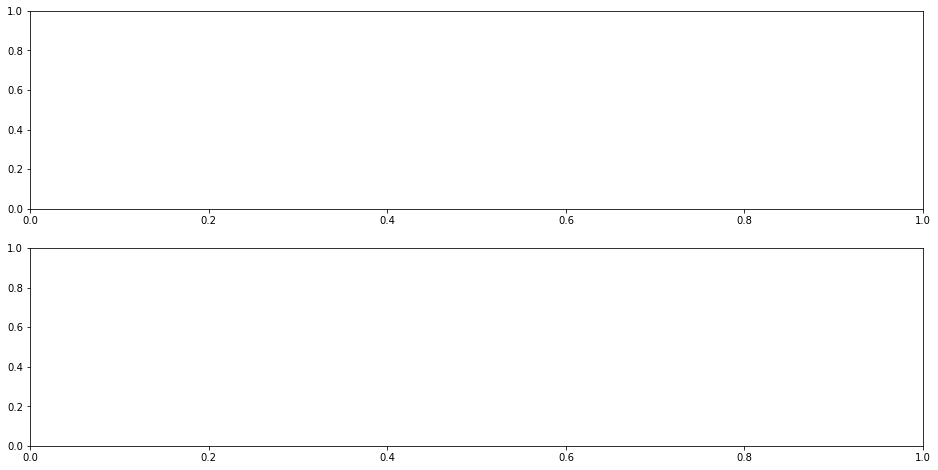

In [343]:
calmap.calendarplot(data=compound_score_calmap_series, fig_kws=dict(figsize=(16,8)))